<a href="https://colab.research.google.com/github/datSaadat/imdb_public/blob/main/IMDB_DNN_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py


def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)

    assert (np.shape(A) == np.shape(Z))
    # print(f"SOFTMAX OUTPUT = {A}")
    cache = Z
    return A, cache


def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    # print(f"SIGMOID OUTPUT = {A}")
    return A, cache


def relu(Z):
    A = np.maximum(0, Z)

    assert (A.shape == Z.shape)

    # print(f"RELU OUTPUT = {A}")

    cache = Z
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


def sigmoid_backward(dA, cache):
    Z = cache

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, cache):
    Z = cache

    s = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)
    return dZ


def linear_forward(A_prev, W, b):
    # Inputs: A_prev (or Input X which is A[0]); Parameters= W, b
    # Outputs: Z; activation_cache = A_prev and parameters

    Z = np.dot(W, A_prev) + b

    assert (Z.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    # Inputs: A_prev, W, b
    # Outputs: A; cache = linear_cache (A_prev, W, b), activation_cache (Z)

    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = sigmoid(Z)  # This "activation_cache" contains "Z"

    elif activation == "relu":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = relu(Z)  # This "activation_cache" contains "Z"

    elif activation == "softmax":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = softmax(Z)  # This "activation_cache" contains "Z"

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def model_forward(X, parameters):
    # Inputs: X (sample inputs), parameters (W,b)
    # Output: Output of Final layer; cache = (linear_cache, activation_cache)
    # linear_cache = A_prev, W, b
    # activation_cache = Z

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    final_layer_dims = parameters['b' + str(L)].shape[0]

    if final_layer_dims == 1:
        AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    else:
        AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")

    caches.append(cache)

    # assert (AL.shape == (1, X.shape[1]))  # (1,m)

    return AL, caches


def predict(X, y, parameters):
    m = X.shape[1]
    # print(m)
    n_y = y.shape[0]
    n = len(parameters) // 2  # number of layers in the neural network

    # Forward propagation
    probas, caches = model_forward(X, parameters)

    # convert probas to 0/1 predictions
    if n_y == 1:
        p = np.round(probas)
        accm = np.sum((p == y) / m)
    else:
        probasT = probas.T
        a = np.zeros_like(probasT)
        a[np.arange(len(probasT)), probasT.argmax(1)] = 1
        p = a.T
        s = y - p
        s_mod = np.where(s > 0, s, 0)
        accm = (1 - np.sum(s_mod) / m)

    print("Accuracy: " + str(accm))

    return p


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
# from supp_func import *
import random
from random import sample


def initialize_parameters(layer_dims):
    # Inputs : layer_dims an array having dimensions of each layer including *Inputs Samples*
    # Outputs: Initialized parameters of all layers

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(1/layer_dims[l - 1])  # *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A_prev, W, b):
    # Inputs: A_prev (or Input X which is A[0]); Parameters= W, b
    # Outputs: Z; activation_cache = A_prev and parameters

    Z = np.dot(W, A_prev) + b

    assert (Z.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    # Inputs: A_prev, W, b
    # Outputs: A; cache = linear_cache (A_prev, W, b), activation_cache (Z)

    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = sigmoid(Z)  # This "activation_cache" contains "Z"

    elif activation == "relu":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = relu(Z)  # This "activation_cache" contains "Z"

    elif activation == "softmax":

        Z, linear_cache = linear_forward(A_prev, W, b)  # This "linear_cache" contains (A_prev, W, b)
        A, activation_cache = softmax(Z)  # This "activation_cache" contains "Z"

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def model_forward(X, parameters):
    # Inputs: X (sample inputs), parameters (W,b)
    # Output: Output of Final layer; cache = (linear_cache, activation_cache)
    # linear_cache = A_prev, W, b
    # activation_cache = Z

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    final_layer_dims = parameters['b' + str(L)].shape[0]

    if final_layer_dims == 1:
        AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    else:
        AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")

    caches.append(cache)

    # assert (AL.shape == (1, X.shape[1]))  # (1,m)

    return AL, caches


def compute_cost(AL, Y):
    # Inputs: AL, Actual Outputs
    # Out[puts: Cost

    m = Y.shape[1]
    cost = np.multiply(Y, np.log(AL))+np.multiply((1-Y), np.log(1-AL))
    cost = np.sum(cost)
    cost = -1* cost/m

    return cost


def linear_backward(dZ, linear_cache):
    # Inputs:
    # Outputs:

    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    # dW = np.dot(dZ, A_prev.T)
    # db = np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    # Inputs:
    # Outputs:

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def model_backward(AL, Y, caches):
    # Inputs:
    # Outputs:

    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL
    final_layer_dims = Y.shape[0]

    # Initializing the backpropagation

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]

    current_cache = caches[L - 1]  # Last Layer

    if final_layer_dims == 1:
        grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,
                                                                                                      current_cache,
                                                                                                      "sigmoid")
    else:
        grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,
                                                                                                          current_cache,
                                                                                                          "softmax")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        ''' Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] ,
         grads["db" + str(l + 1)]'''

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters


def dnn_model(X_input, Y_input, layers_dims, epochs, val_percentage=0, learning_rate=0.002, batch_size = 1, print_cost=False):

    input_indices = list(range(0, X_input.shape[1]))
    val_indices_count = int(X_input.shape[1] * val_percentage)
    val_indices = random.sample(input_indices, val_indices_count)

    X_val = X_input[:, val_indices]
    Y_val = Y_input[:, val_indices]

    train_indices = [ele for ele in input_indices if ele not in val_indices]
    X_train = X_input[:, train_indices]
    Y_train = Y_input[:, train_indices]

    elements_in_each_batch = int(X_train.shape[1] / batch_size)

    np.random.seed(1)
    costs = []  # keep track of cost
    costs_val = []
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, epochs):
        indices = list(range(0, X_train.shape[1]))

        if batch_size == 1:
            X = X_train
            Y = Y_train

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = model_forward(X, parameters)

            # Compute cost.
            cost = compute_cost(AL, Y)

            # Backward propagation.
            grads = model_backward(AL, Y, caches)

            # Update parameters.
            parameters = update_parameters(parameters, grads, learning_rate)

        else:
            for j in range(0, batch_size):

                batch_train_indices = random.sample(indices, elements_in_each_batch)
                unwanted_num = batch_train_indices
                indices = [ele for ele in indices if ele not in unwanted_num]

                X = X_train[:, batch_train_indices]
                Y = Y_train[:, batch_train_indices]

                AL, caches = model_forward(X, parameters)

                # Compute cost.
                cost = compute_cost(AL, Y)

                # Backward propagation.
                grads = model_backward(AL, Y, caches)

                # Update parameters.
                parameters = update_parameters(parameters, grads, learning_rate)



        # Print the cost every 100 training example
        print("Cost after iteration %i: %f" % (i, cost))

        costs.append(cost)

        AL_val, caches_val = model_forward(X_val, parameters)
        cost_val = compute_cost(AL_val, Y_val)
        print("Validation Cost after iteration %i: %f" % (i, cost_val))
        costs_val.append(cost_val)



    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(costs_val), linestyle = "dotted")
    plt.ylabel('cost')
    plt.xlabel('iterations ')
    # plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters



In [1]:
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


In [5]:
print(np.shape(train_data))
print(train_data[1])

(25000,)
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


In [ ]:
import numpy as np

def hot_encoding(array):

    hot_encoded_out = []
    x = list(range(min(array),max(array)+1))

    for i in range (0,len(array)):
        hot_encoded_out.append(((x == array[i]).astype(int)))

    return np.array(hot_encoded_out).T

In [ ]:



''' Hot Encoding of data '''


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = hot_encoding(train_labels)
y_test = hot_encoding(test_labels)

# y_train = np.asarray(train_labels).astype("float32")
# y_test = np.asarray(test_labels).astype("float32")



In [ ]:
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

# y_train = np.reshape(y_train, (1, 25000))
# y_test = np.reshape(y_test, (1, 25000))
x_train = x_train.T
x_test = x_test.T


print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(y_train))
print(np.shape(y_test))

(25000, 10000)
(25000, 10000)
(2, 25000)
(2, 25000)
(10000, 25000)
(10000, 25000)
(2, 25000)
(2, 25000)


Cost after iteration 0: 1.369754
Validation Cost after iteration 0: 1.363711
Cost after iteration 1: 1.318093
Validation Cost after iteration 1: 1.326720
Cost after iteration 2: 1.221606
Validation Cost after iteration 2: 1.266443
Cost after iteration 3: 1.198933
Validation Cost after iteration 3: 1.192650
Cost after iteration 4: 1.013207
Validation Cost after iteration 4: 1.116596
Cost after iteration 5: 0.948204
Validation Cost after iteration 5: 1.044100
Cost after iteration 6: 1.030329
Validation Cost after iteration 6: 0.977200
Cost after iteration 7: 1.046934
Validation Cost after iteration 7: 0.917908
Cost after iteration 8: 0.821426
Validation Cost after iteration 8: 0.867493
Cost after iteration 9: 0.793207
Validation Cost after iteration 9: 0.825380
Cost after iteration 10: 0.705857
Validation Cost after iteration 10: 0.793011
Cost after iteration 11: 0.730636
Validation Cost after iteration 11: 0.761437
Cost after iteration 12: 0.739340
Validation Cost after iteration 12: 0.

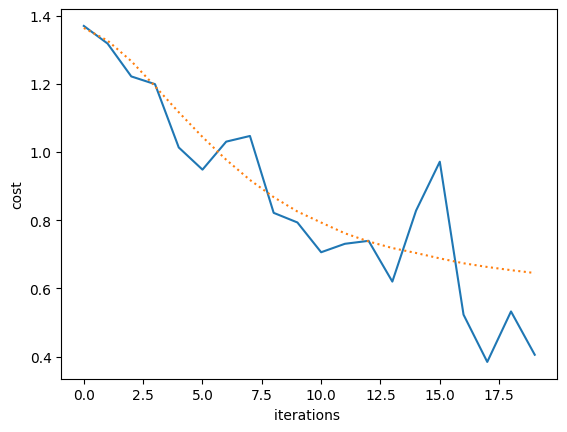

Accuracy: 0.88192
Accuracy: 0.86648


In [ ]:

layers_dims = [x_train.shape[0], 64, 32, 2]

parameters = dnn_model(x_train, y_train, layers_dims, val_percentage=.35, epochs= 20, batch_size = 512, print_cost = True, learning_rate=.001)

pred_train = predict(x_train, y_train, parameters)

pred_test = predict(x_test, y_test, parameters)